In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import joblib
import math
import ast
import logging
from pathlib import Path  
from msig import Motif, NullModel

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Load YAML configuration
config_path = "config.yaml" 
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

BASE_DIR = Path(config["base_dir"]).resolve()

RESULTS_DIR = BASE_DIR / config["results_dir"]
IMAGES_DIR = BASE_DIR / config["images_dir"]
DATA_DIR = BASE_DIR / config["data_dir"]
DATASET_PATH = BASE_DIR / config["dataset_path"]
RESULTS_MOTIF_DIR = BASE_DIR / config["results_motif_dir"]

VARIABLES = config["variables"]
NORMALIZE_FLAGS = config["normalize_flags"]
STUMPY_EXCL_ZONE_DENOM = config["stumpy_excl_zone_denom"]
TOP_K_MP = config["top_k_mp"]
INCLUDE = config["include"]
NORMALIZE = config["normalize"]
SUBSEQUENCES_LENGTHS = config["subsequences_lengths"]
NTOP_MOTIFS = config["ntop_motifs"]
MOTIF_SIZE = config["motif_size"]
LOOKBACK_PERIOD = config["lookback_period"]
STEP = config["step"]
FORECAST_PERIOD = config["forecast_period"]

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")
print(f"Dataset path: {DATASET_PATH}")

if '__file__' in globals():
    # For standalone scripts
    base_dir = Path(__file__).parent.resolve()
else:
    # For Jupyter or interactive environments
    base_dir = Path(os.getcwd()).resolve()

sys.path.append(str(base_dir / "../"))

Results will be saved in: /home/mgsilva/motifpred/results/household
Images will be saved in: /home/mgsilva/motifpred/images/household
Data will be accessed from: /home/mgsilva/motifpred/data/household
Dataset path: /home/mgsilva/motifpred/data/household/data_5min_resampled_globalactive_reactive.csv


In [2]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
mp_stats_table = mp_stats_table[mp_stats_table["m"] == MOTIF_SIZE]
top_motifs = mp_stats_table.sort_values(by=["#Matches", "ID"], ascending=[False, True]).head(NTOP_MOTIFS)
top_motifs = top_motifs[["m", "Indices"]]

In [3]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [4]:
#load data as 
data_df = pd.read_csv(DATASET_PATH, index_col=0).astype(float)
data_df = data_df[VARIABLES]
data = data_df.values.T
data

array([[1.2944, 1.3644, 1.4672, ..., 0.7808, 0.7676, 0.634 ],
       [0.    , 0.0776, 0.2188, ..., 0.1644, 0.1492, 0.0608]])

In [5]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.ffnn_pytorch import FFNN
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test


test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():
    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i+1} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes ")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "FFNN"
    model_name = "FFNNSeries"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1, 2, 3, 4]] 
        },        
        "batch_size": {
            "type": "categorical",
            "args": [[16, 32, 64, 128]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")

Evaluating motif 6 with size 24 and 359 indexes 
X_series shape: torch.Size([2977, 576, 2])
X_indices shape: torch.Size([2977, 22, 1])
X_mask shape: torch.Size([2977, 576])
y shape: torch.Size([2977, 1])
Best epoch: 13
Test Loss: 1370.103759765625, Test MAE: 25.591468811035156, Test RMSE: 37.01491165161133
Evaluating motif 18 with size 24 and 358 indexes 
X_series shape: torch.Size([2974, 576, 2])
X_indices shape: torch.Size([2974, 20, 1])
X_mask shape: torch.Size([2974, 576])
y shape: torch.Size([2974, 1])
Best epoch: 39
Test Loss: 1150.0054931640625, Test MAE: 26.0207462310791, Test RMSE: 33.9117317199707
Evaluating motif 2 with size 24 and 298 indexes 
X_series shape: torch.Size([2987, 576, 2])
X_indices shape: torch.Size([2987, 17, 1])
X_mask shape: torch.Size([2987, 576])
y shape: torch.Size([2987, 1])
Best epoch: 9
Test Loss: 1354.326171875, Test MAE: 29.487443923950195, Test RMSE: 36.801170349121094
Evaluating motif 8 with size 24 and 279 indexes 
X_series shape: torch.Size([298

Evaluating motif 5 with size 24 and 359 indexes 


X_series shape: torch.Size([2977, 576, 2])
X_indices shape: torch.Size([2977, 22, 1])
X_mask shape: torch.Size([2977, 576])
y shape: torch.Size([2977, 1])
Best epoch: 47
Test Loss: 1266.3302001953125, Test MAE: 26.125835418701172, Test RMSE: 35.585533142089844
Best hyperparameters: {'learning_rate': 3.8426905357193906e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 32}
Early stopping at epoch 58, with best epoch being 47


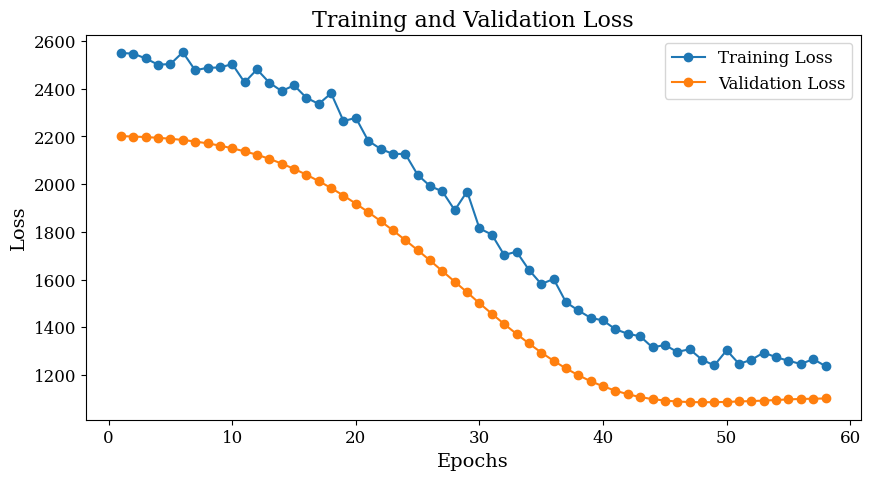

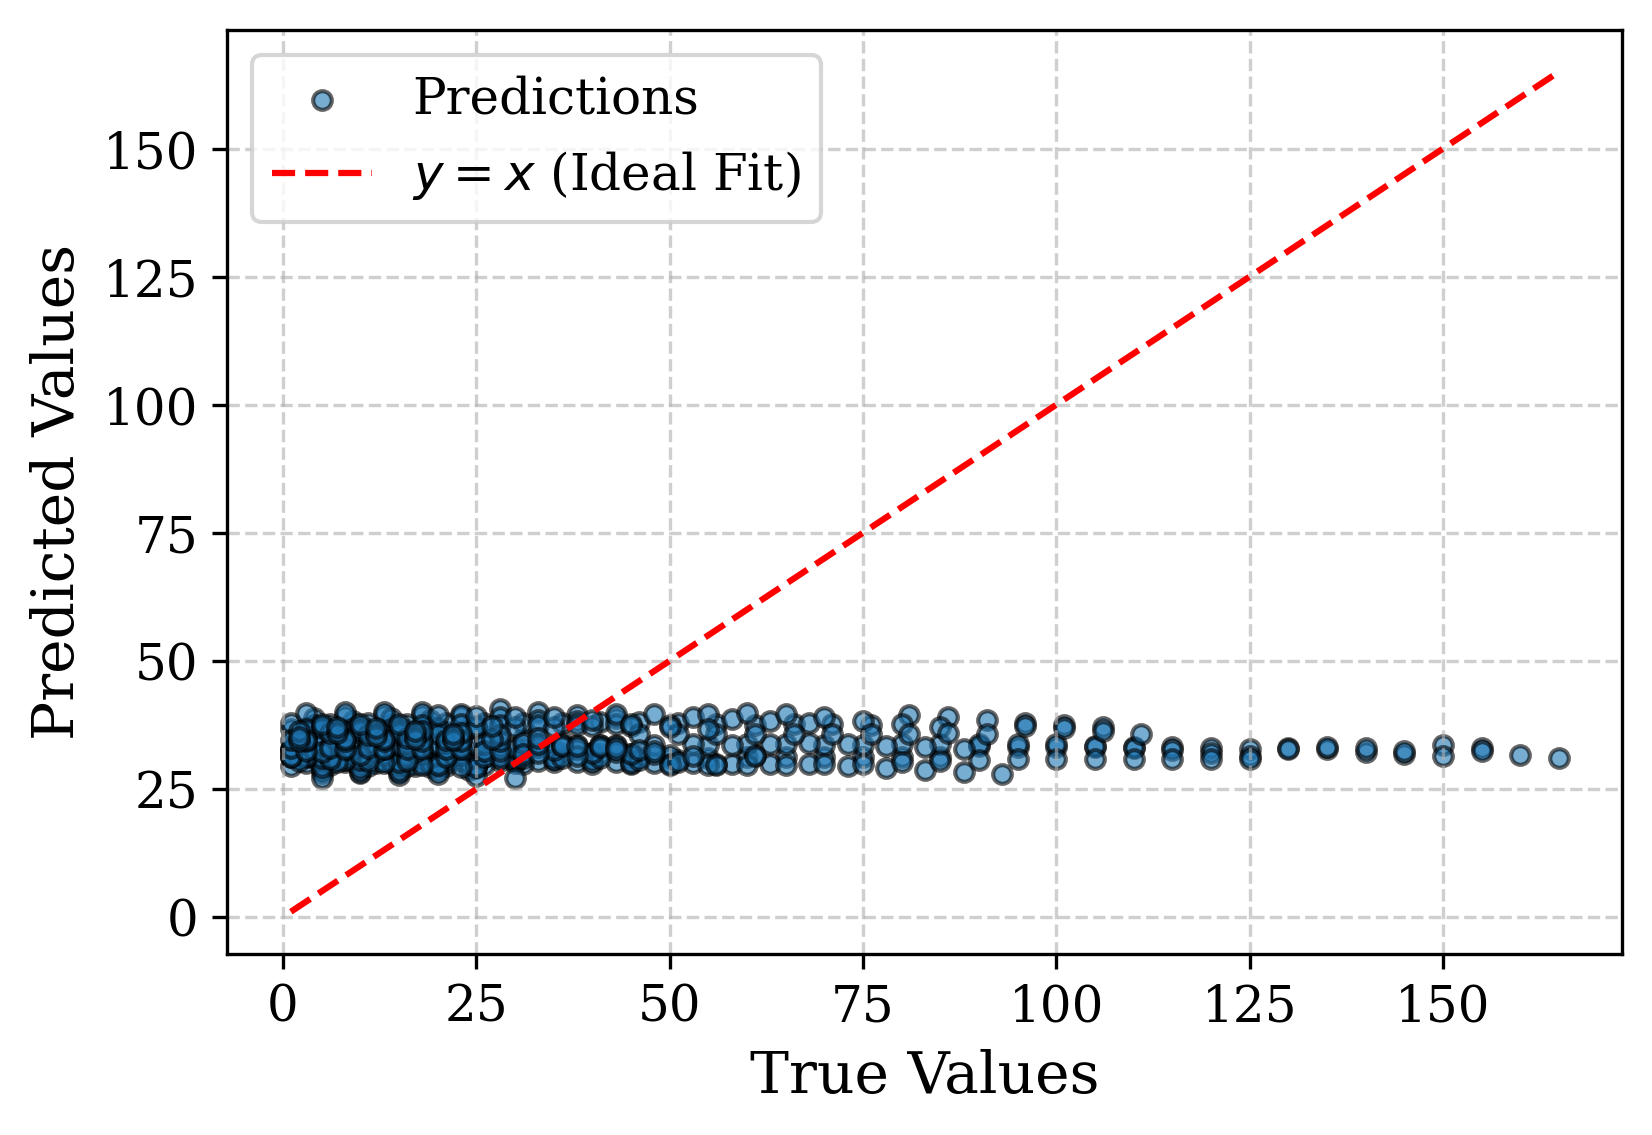

Evaluating motif 17 with size 24 and 358 indexes 
X_series shape: torch.Size([2974, 576, 2])
X_indices shape: torch.Size([2974, 20, 1])
X_mask shape: torch.Size([2974, 576])
y shape: torch.Size([2974, 1])
Best epoch: 1
Test Loss: 1362.4154052734375, Test MAE: 27.334753036499023, Test RMSE: 36.910911560058594
Best hyperparameters: {'learning_rate': 0.00039441813130526284, 'num_layers': 4, 'batch_size': 16, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 128, 'hidden_size_layer_3': 32}
Early stopping at epoch 12, with best epoch being 1


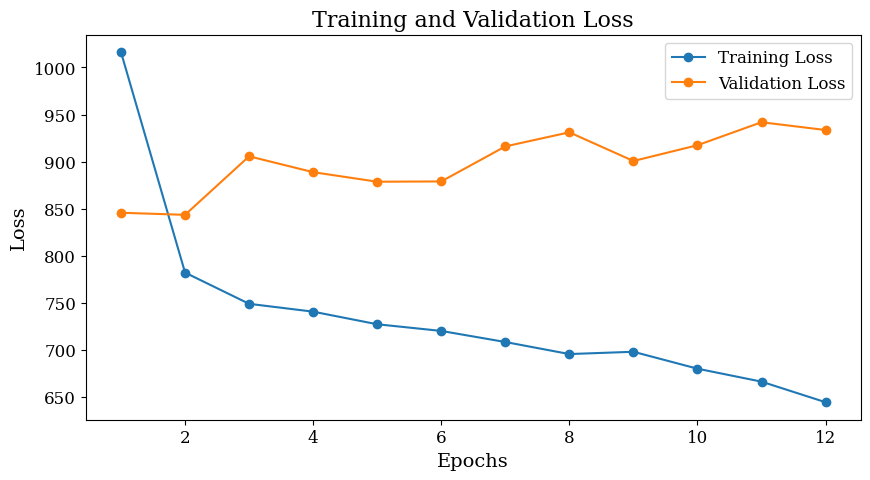

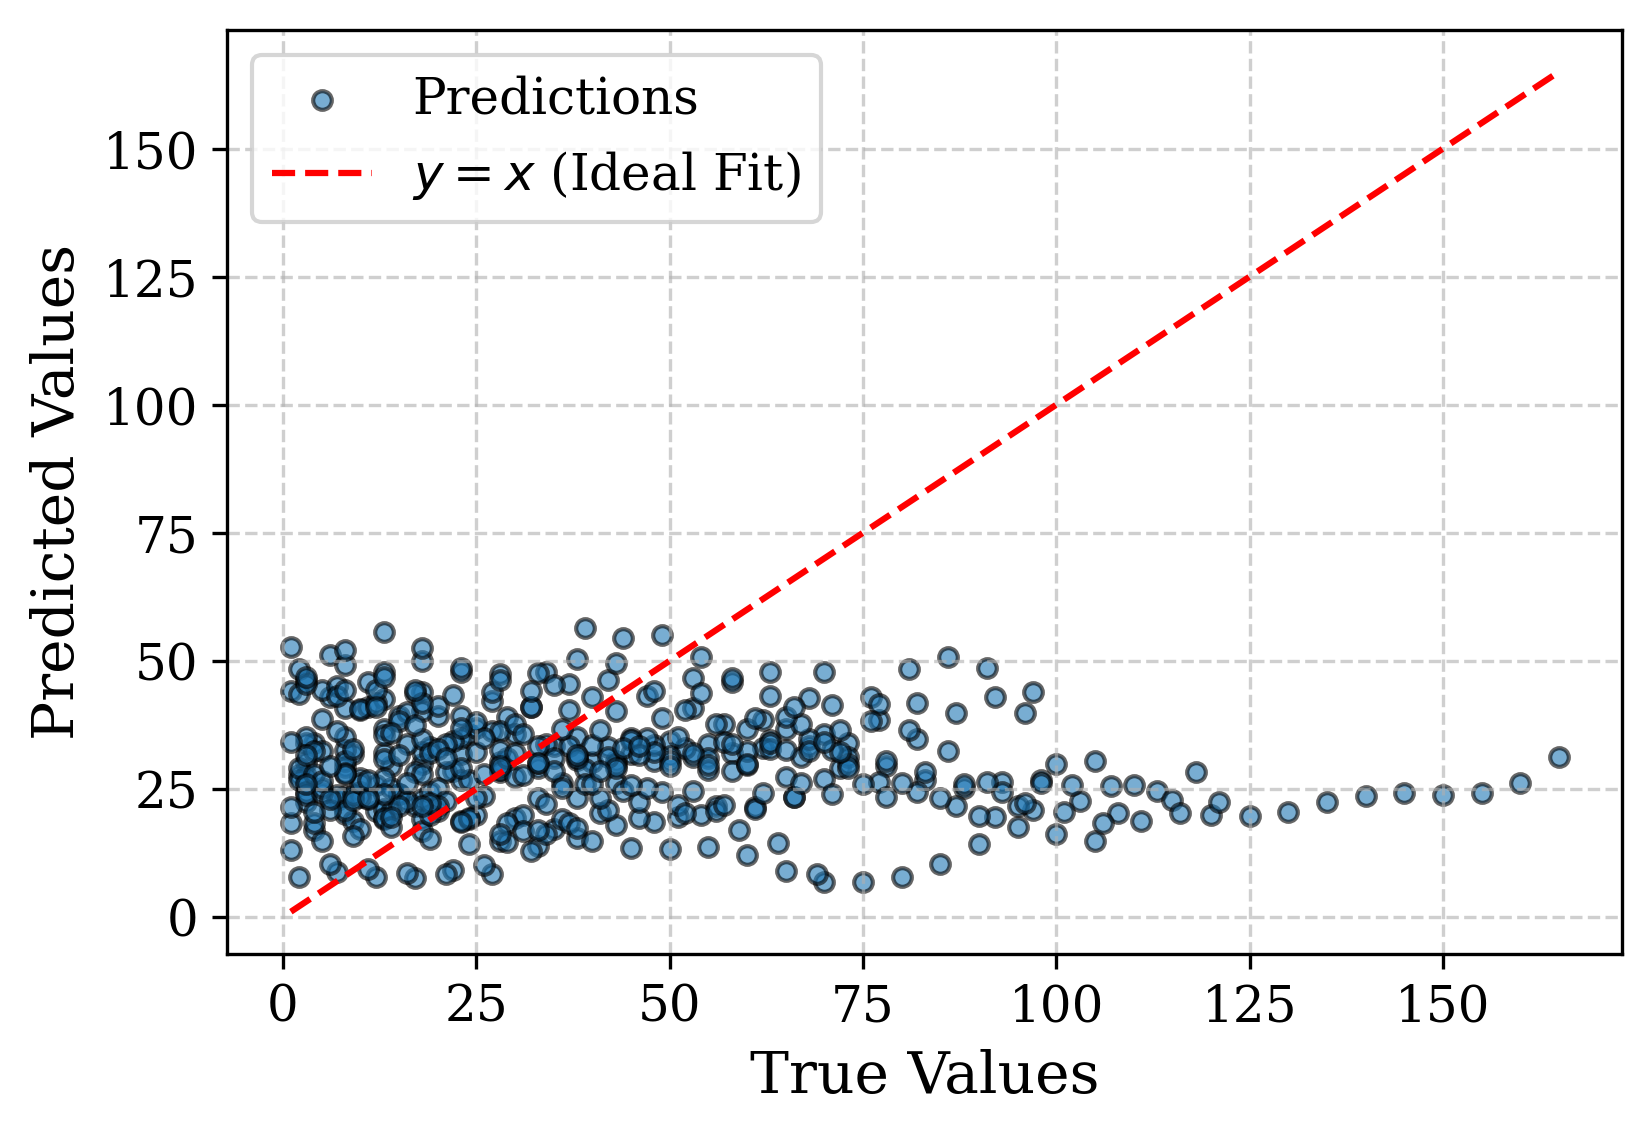

Evaluating motif 1 with size 24 and 298 indexes 
X_series shape: torch.Size([2987, 576, 2])
X_indices shape: torch.Size([2987, 17, 1])
X_mask shape: torch.Size([2987, 576])
y shape: torch.Size([2987, 1])
Best epoch: 10
Test Loss: 1232.6297607421875, Test MAE: 29.6568660736084, Test RMSE: 35.10882568359375
Best hyperparameters: {'learning_rate': 8.217556374099035e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 256, 'hidden_size_layer_2': 64}
Early stopping at epoch 21, with best epoch being 10


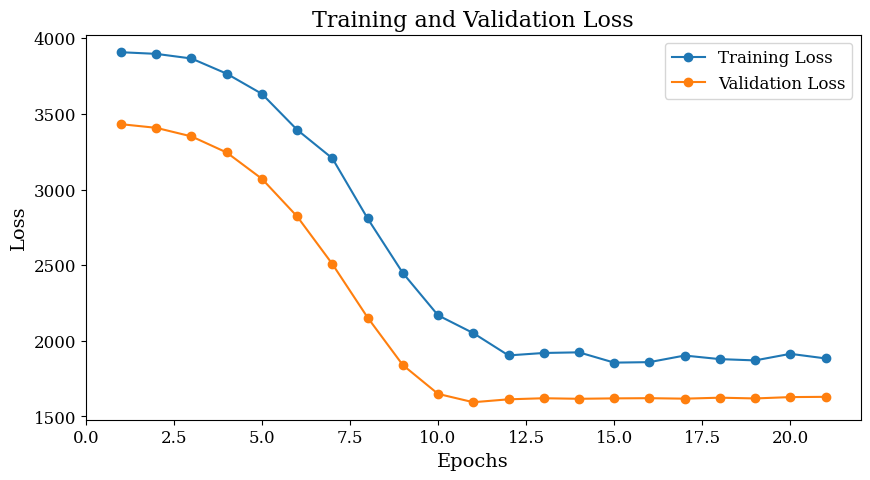

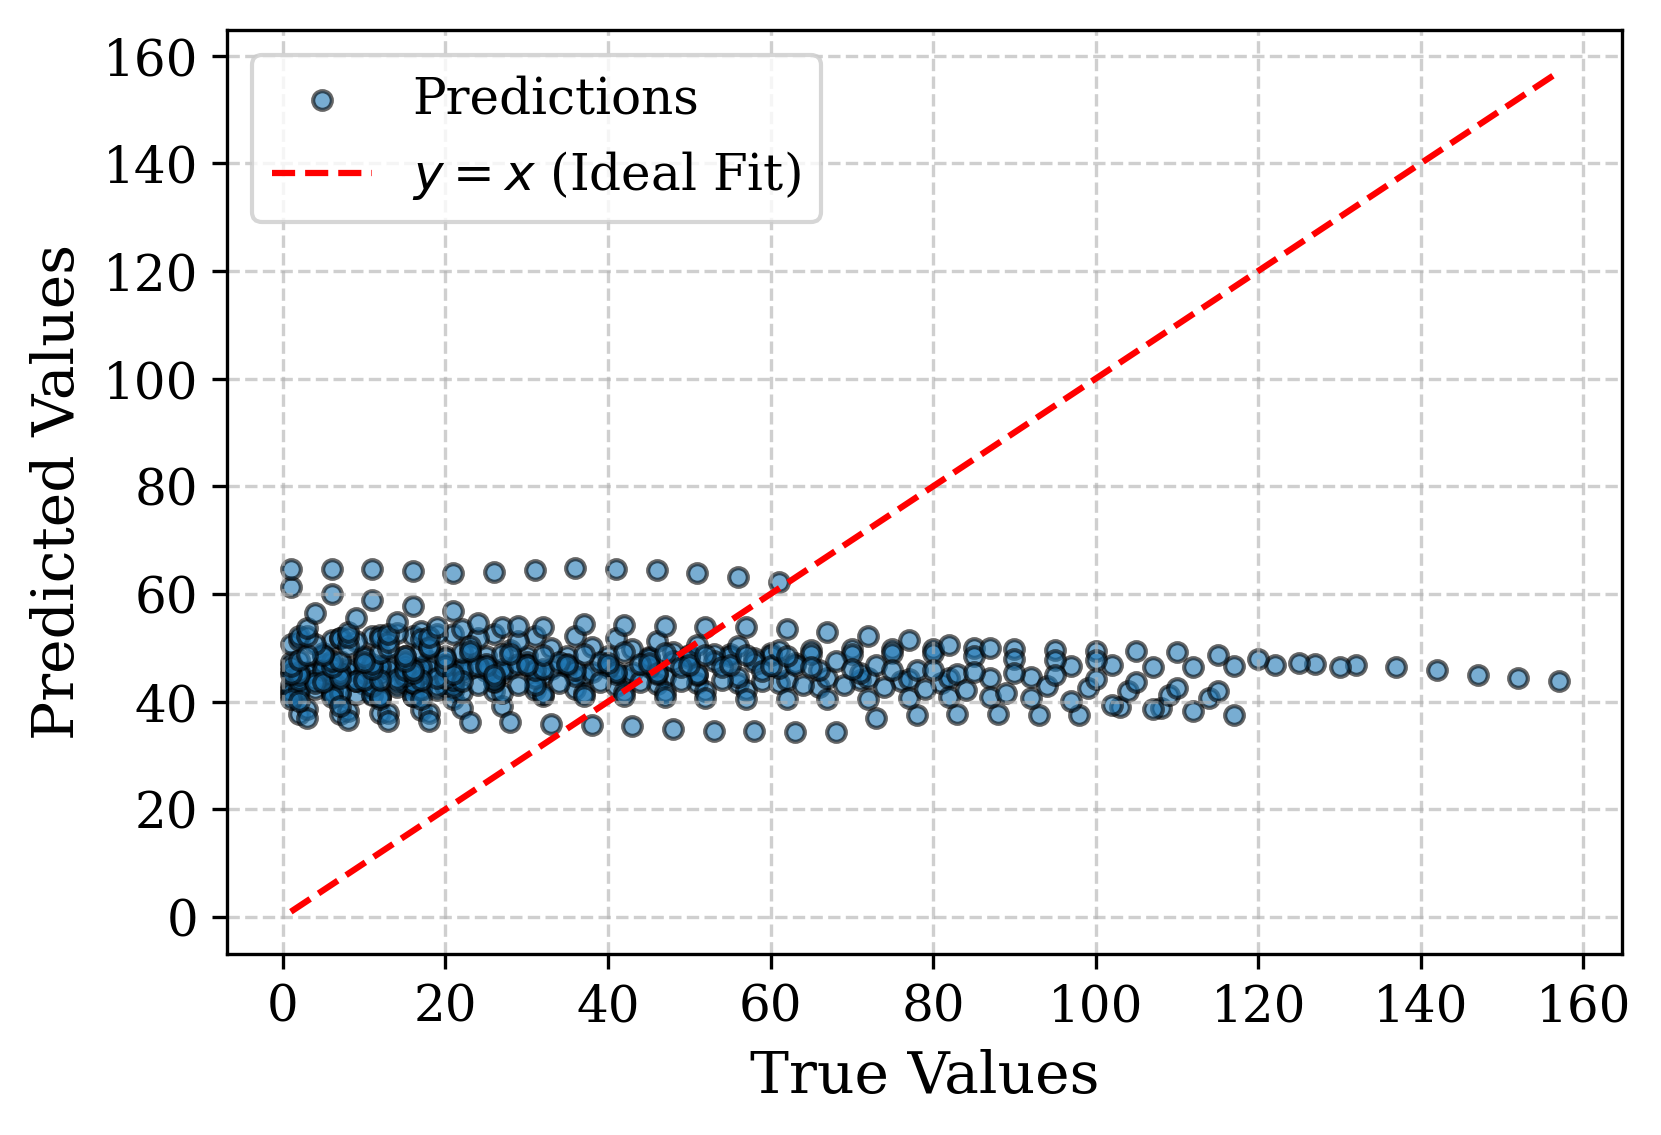

Evaluating motif 7 with size 24 and 279 indexes 
X_series shape: torch.Size([2984, 576, 2])
X_indices shape: torch.Size([2984, 22, 1])
X_mask shape: torch.Size([2984, 576])
y shape: torch.Size([2984, 1])
Best epoch: 1
Test Loss: 4809.0615234375, Test MAE: 49.82380676269531, Test RMSE: 69.34739685058594
Best hyperparameters: {'learning_rate': 0.0007202491708371224, 'num_layers': 4, 'batch_size': 128, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 256, 'hidden_size_layer_2': 128, 'hidden_size_layer_3': 128}
Early stopping at epoch 12, with best epoch being 1


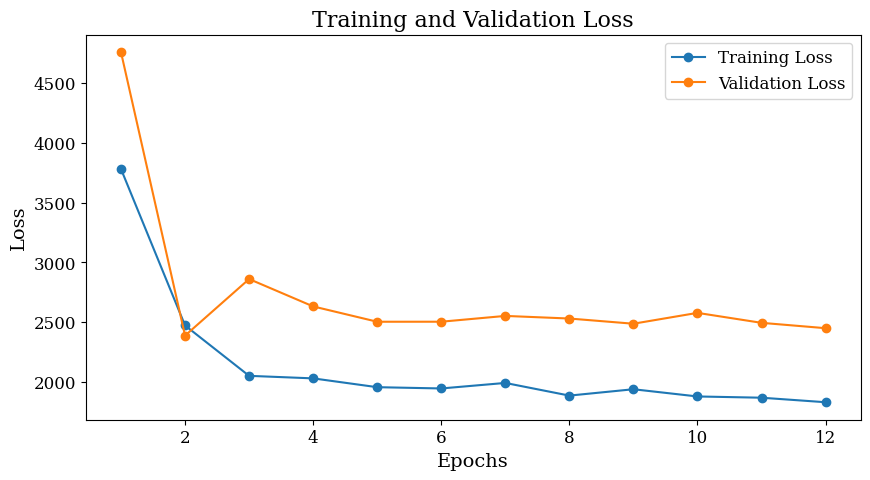

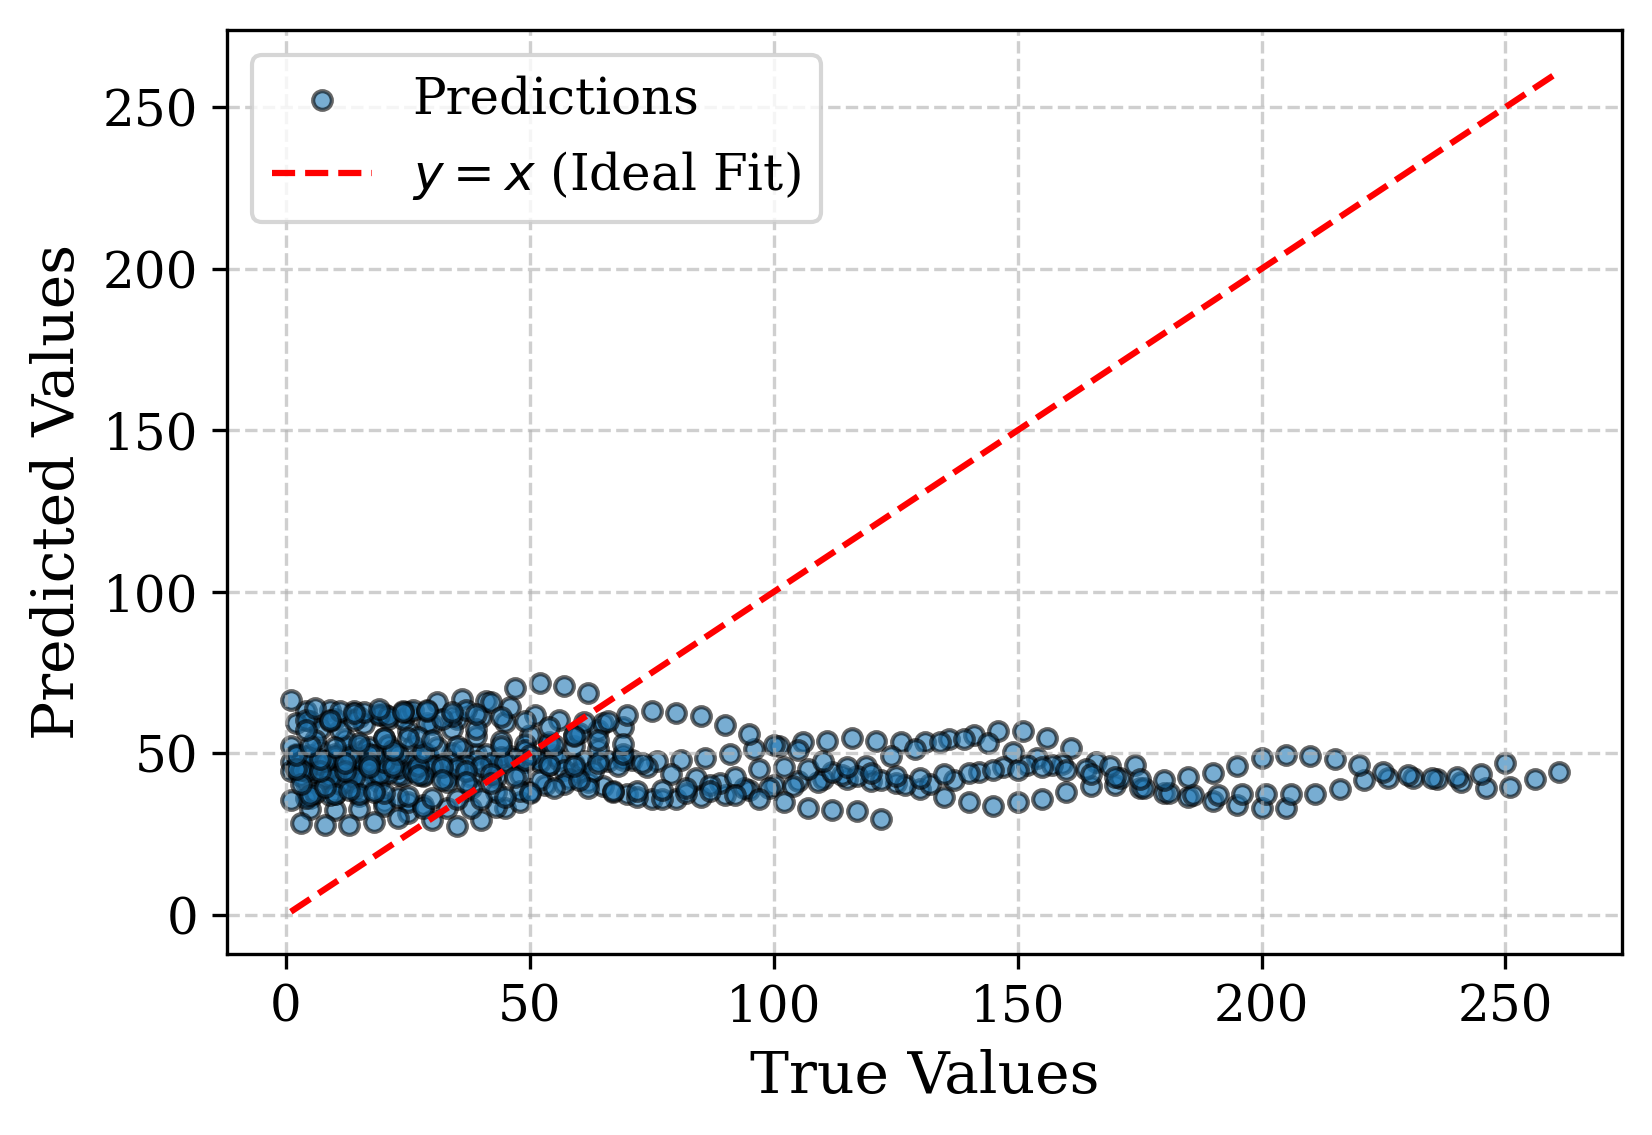

Evaluating motif 6 with size 24 and 268 indexes 
X_series shape: torch.Size([2887, 576, 2])
X_indices shape: torch.Size([2887, 25, 1])
X_mask shape: torch.Size([2887, 576])
y shape: torch.Size([2887, 1])
Best epoch: 8
Test Loss: 2360.274169921875, Test MAE: 33.400978088378906, Test RMSE: 48.5826530456543
Best hyperparameters: {'learning_rate': 0.0008398511326801563, 'num_layers': 3, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 256}
Early stopping at epoch 19, with best epoch being 8


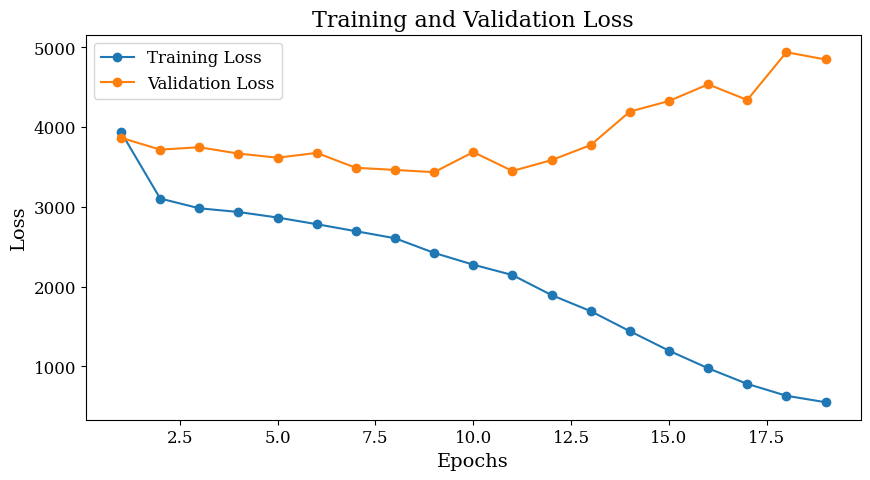

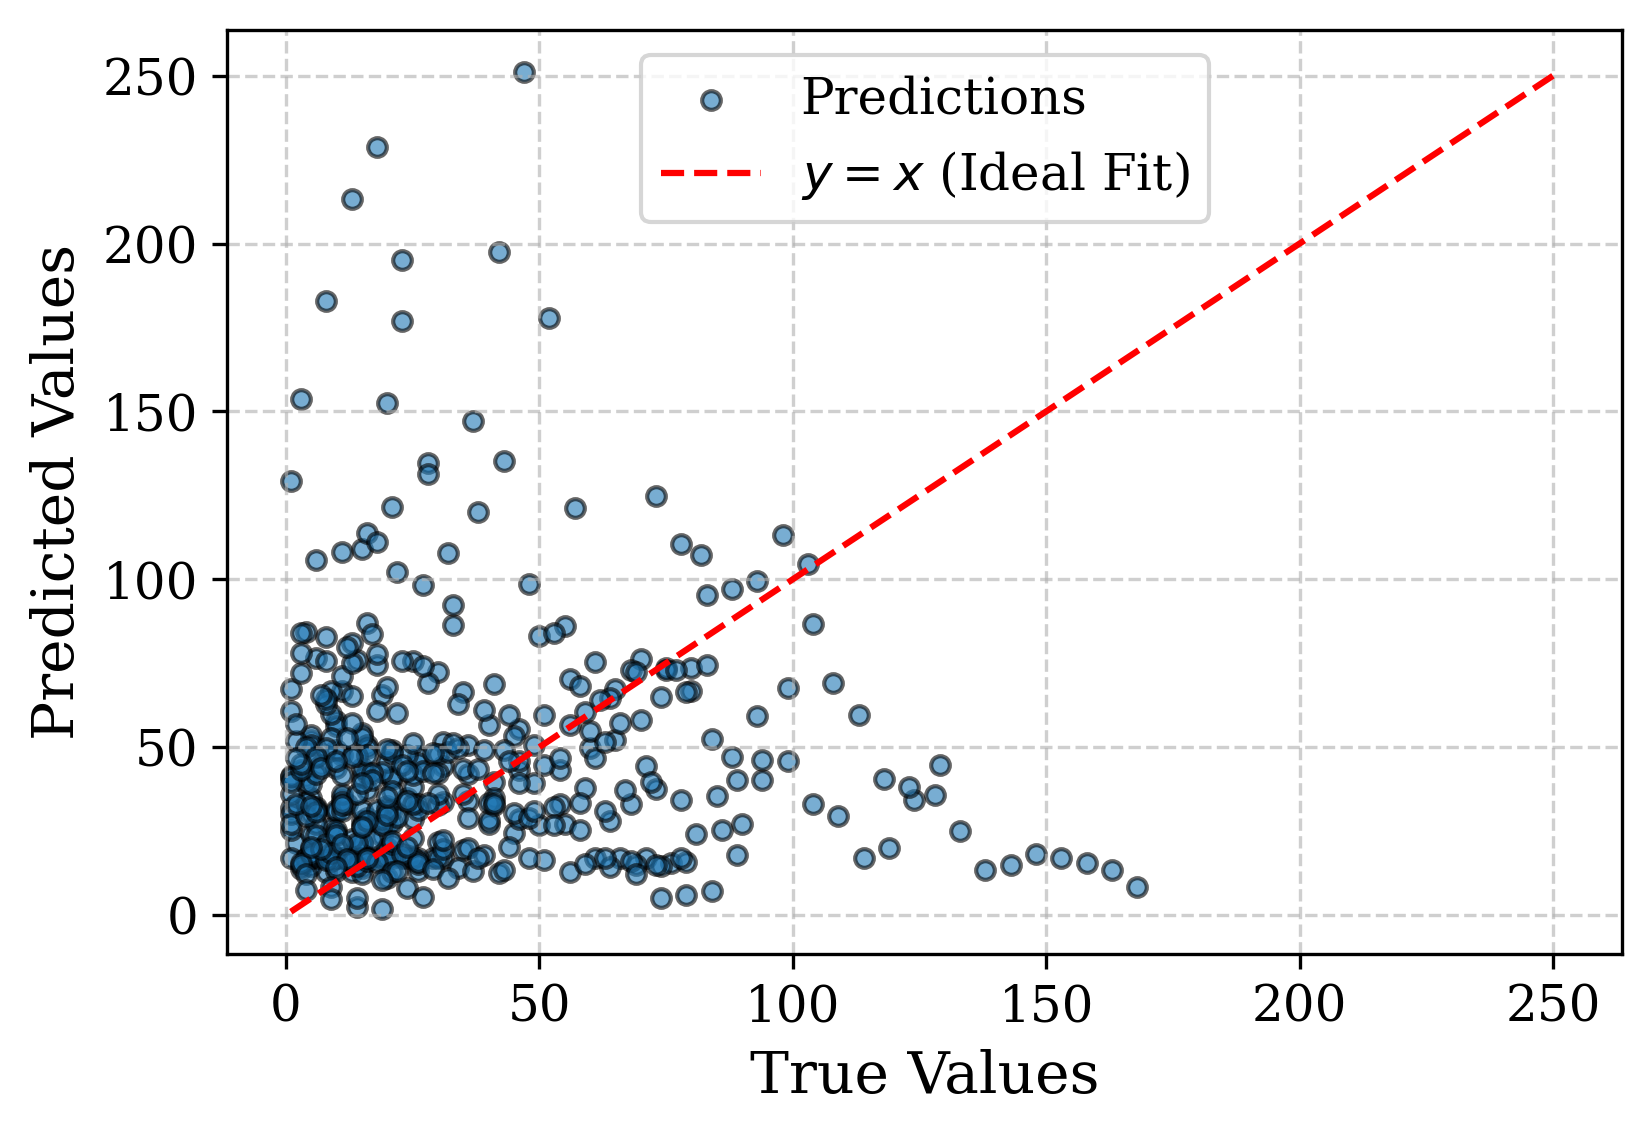

Aggregated Results Across Top 5 Motifs:
Mean Test Loss: 2206.1422119140625 ± 1366.8791926854744
Mean Test MAE: 33.26844787597656 ± 8.641373066860634
Mean Test RMSE: 45.10706405639648 ± 13.095607584606487


In [6]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.ffnn_pytorch import FFNN
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():
    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes ")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "FFNN"
    model_name = "FFNNSeries_Masking"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1, 2, 3, 4]] 
        },        
        "batch_size": {
            "type": "categorical",
            "args": [[16, 32, 64, 128]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series, "X_mask": X_mask}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    plot_best_model_results_traindevtest( study.trials_dataframe(),
       save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    )    
    plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


In [8]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.ffnn_pytorch import FFNN
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test


test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():
    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i+1} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes ")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "FFNN"
    model_name = "FFNNIndexes"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1, 2, 3, 4]] 
        },        
        "batch_size": {
            "type": "categorical",
            "args": [[16, 32, 64, 128]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_indices": X_indices}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


Evaluating motif 6 with size 24 and 359 indexes 
X_series shape: torch.Size([2977, 576, 2])
X_indices shape: torch.Size([2977, 22, 1])
X_mask shape: torch.Size([2977, 576])
y shape: torch.Size([2977, 1])
Best epoch: 95
Test Loss: 1511.0205078125, Test MAE: 28.169261932373047, Test RMSE: 38.871849060058594
Evaluating motif 18 with size 24 and 358 indexes 
X_series shape: torch.Size([2974, 576, 2])
X_indices shape: torch.Size([2974, 20, 1])
X_mask shape: torch.Size([2974, 576])
y shape: torch.Size([2974, 1])
Best epoch: 4
Test Loss: 1360.932373046875, Test MAE: 26.92951011657715, Test RMSE: 36.89081573486328
Evaluating motif 2 with size 24 and 298 indexes 
X_series shape: torch.Size([2987, 576, 2])
X_indices shape: torch.Size([2987, 17, 1])
X_mask shape: torch.Size([2987, 576])
y shape: torch.Size([2987, 1])
Best epoch: 129
Test Loss: 1279.9879150390625, Test MAE: 29.307514190673828, Test RMSE: 35.776920318603516
Evaluating motif 8 with size 24 and 279 indexes 
X_series shape: torch.Size